In [1]:
from os import path, listdir
from PIL import Image
import numpy as np

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
def get_data(directory: str) -> "tuple[np.ndarray, np.ndarray]":
    ima = listdir(path.join(directory, "PNEUMONIA"))
    nema = listdir(path.join(directory, "NORMAL"))
    size = len(ima) + len(nema)
    X = np.empty((size, 250, 350), dtype=np.uint8)
    y = np.empty((size), dtype=np.uint8)
    for i, file in enumerate(ima):
        X[i] = np.asarray(Image.open(path.join(directory, "PNEUMONIA", file)))
        y[i] = 1
    for i, file in enumerate(nema):
        X[len(ima) + i] = np.asarray(Image.open(path.join(directory, "NORMAL", file)))
        y[len(ima) + i] = 0
    return X , y

In [5]:
from modeli_stefan import make_model_4

In [6]:
directory_train = "../chest_xray_norm/train"
x_train, y_train = get_data(directory_train)

directory_val = "../chest_xray_norm/val"
x_val, y_val = get_data(directory_val)

model = make_model_4(x_train[0].shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 350)]        0         
_________________________________________________________________
rescaling (Rescaling)        (None, 250, 350)          0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 250, 350)          0         
_________________________________________________________________
tf.clip_by_value (TFOpLambda (None, 250, 350)          0         
_________________________________________________________________
reshape (Reshape)            (None, 250, 350, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 348, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 174, 8)       0     

In [7]:
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
class MyModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch,logs)\

        # Also save the optimizer state
        filepath = self._get_file_path(epoch=epoch, 
            logs=logs)
        filepath = filepath.rsplit( ".", 1 )[ 0 ] 
        filepath += ".pkl"

        with open(filepath, 'wb') as fp:
              pickle.dump(
                {
                  'opt': model.optimizer.get_config(),
                  'epoch': epoch+1
                 # Add additional keys if you need to store more values
                }, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('\nEpoch %05d: saving optimizaer to %s' % (epoch + 1, filepath))

In [13]:
save_dir = "./checkpoints/stefan/model_4"

In [14]:
checkpoint_cb = MyModelCheckpoint(
path.join(save_dir, 'model-{epoch:03d}-{val_loss:.5f}.hdf5'),
monitor='val_loss',verbose=1)

In [15]:
history = model.fit(x_train, y_train, epochs=100, batch_size=0, verbose=1,
                    shuffle=True, validation_data=(x_val,y_val),callbacks=[checkpoint_cb])

Epoch 1/100
163/163 [==============================] - 12s 73ms/step - loss: 0.1131 - accuracy: 0.9578 - precision: 0.9726 - recall: 0.9706 - val_loss: 0.4051 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00001: saving model to ./checkpoints/stefan/model_4/model-001-0.40513.hdf5

Epoch 00001: saving optimizaer to ./checkpoints/stefan/model_4/model-001-0.40513.pkl
Epoch 2/100
163/163 [==============================] - 12s 74ms/step - loss: 0.0978 - accuracy: 0.9618 - precision: 0.9730 - recall: 0.9757 - val_loss: 0.5392 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000

Epoch 00002: saving model to ./checkpoints/stefan/model_4/model-002-0.53924.hdf5

Epoch 00002: saving optimizaer to ./checkpoints/stefan/model_4/model-002-0.53924.pkl
Epoch 3/100
163/163 [==============================] - 12s 73ms/step - loss: 0.0755 - accuracy: 0.9751 - precision: 0.9830 - recall: 0.9835 - val_loss: 0.4147 - val_accuracy: 0.8125 - val_precision: 0.7273 - va

163/163 [==============================] - 12s 73ms/step - loss: 0.0101 - accuracy: 0.9971 - precision: 0.9982 - recall: 0.9979 - val_loss: 1.1332 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000

Epoch 00022: saving model to ./checkpoints/stefan/model_4/model-022-1.13325.hdf5

Epoch 00022: saving optimizaer to ./checkpoints/stefan/model_4/model-022-1.13325.pkl
Epoch 23/100
163/163 [==============================] - 12s 73ms/step - loss: 0.0162 - accuracy: 0.9939 - precision: 0.9961 - recall: 0.9956 - val_loss: 1.2886 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00023: saving model to ./checkpoints/stefan/model_4/model-023-1.28864.hdf5

Epoch 00023: saving optimizaer to ./checkpoints/stefan/model_4/model-023-1.28864.pkl
Epoch 24/100
163/163 [==============================] - 12s 73ms/step - loss: 0.0128 - accuracy: 0.9950 - precision: 0.9972 - recall: 0.9961 - val_loss: 1.5895 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 

163/163 [==============================] - 12s 72ms/step - loss: 4.0624e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9782 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00043: saving model to ./checkpoints/stefan/model_4/model-043-1.97818.hdf5

Epoch 00043: saving optimizaer to ./checkpoints/stefan/model_4/model-043-1.97818.pkl
Epoch 44/100
163/163 [==============================] - 12s 73ms/step - loss: 3.2128e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9476 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00044: saving model to ./checkpoints/stefan/model_4/model-044-1.94764.hdf5

Epoch 00044: saving optimizaer to ./checkpoints/stefan/model_4/model-044-1.94764.pkl
Epoch 45/100
163/163 [==============================] - 12s 72ms/step - loss: 2.7098e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0366 - val_accuracy: 0.8125 - val_precision: 0.7273 - 


Epoch 00063: saving model to ./checkpoints/stefan/model_4/model-063-2.59065.hdf5

Epoch 00063: saving optimizaer to ./checkpoints/stefan/model_4/model-063-2.59065.pkl
Epoch 64/100
163/163 [==============================] - 12s 73ms/step - loss: 2.5651e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.6261 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00064: saving model to ./checkpoints/stefan/model_4/model-064-2.62611.hdf5

Epoch 00064: saving optimizaer to ./checkpoints/stefan/model_4/model-064-2.62611.pkl
Epoch 65/100
163/163 [==============================] - 12s 73ms/step - loss: 2.5801e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.6194 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00065: saving model to ./checkpoints/stefan/model_4/model-065-2.61939.hdf5

Epoch 00065: saving optimizaer to ./checkpoints/stefan/model_4/model-065-2.61939.pkl
Epoch 66/100
163/163 [==========

163/163 [==============================] - 12s 73ms/step - loss: 4.6641e-08 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.1169 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00084: saving model to ./checkpoints/stefan/model_4/model-084-3.11692.hdf5

Epoch 00084: saving optimizaer to ./checkpoints/stefan/model_4/model-084-3.11692.pkl
Epoch 85/100
163/163 [==============================] - 12s 73ms/step - loss: 4.3431e-08 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.1668 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Epoch 00085: saving model to ./checkpoints/stefan/model_4/model-085-3.16680.hdf5

Epoch 00085: saving optimizaer to ./checkpoints/stefan/model_4/model-085-3.16680.pkl
Epoch 86/100
163/163 [==============================] - 12s 73ms/step - loss: 3.8561e-08 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.1976 - val_accuracy: 0.8125 - val_precision: 0.7273 - 

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [17]:
import matplotlib.pyplot as plt

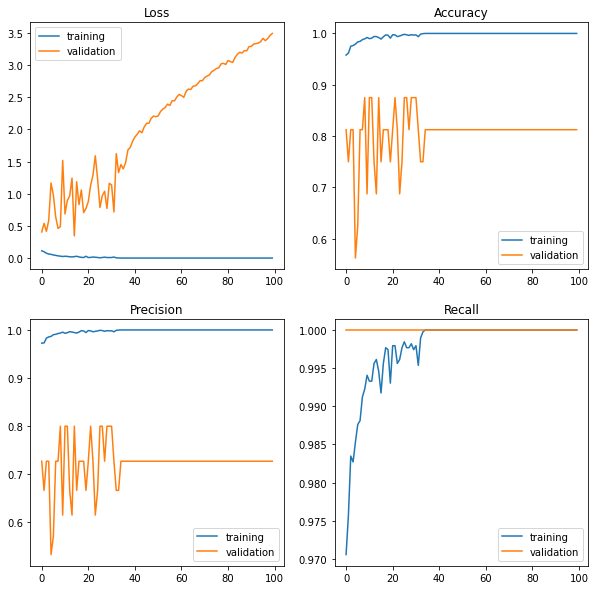

In [19]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Loss')
plt.plot(history.epoch, history.history['loss'], label='training')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 2)
plt.title('Accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 3)
plt.title('Precision')
plt.plot(history.epoch, history.history['precision'], label='training')
plt.plot(history.epoch, history.history['val_precision'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 4)
plt.title('Recall')
plt.plot(history.epoch, history.history['recall'], label='training')
plt.plot(history.epoch, history.history['val_recall'], label='validation')
plt.legend(loc='best')

plt.show()

In [20]:
model.save("./modeli/stefan/model_4_epoha_100.h5")

In [21]:
import json
  
# Serializing json 
json_history = json.dumps(history.history, indent = 4)
  
# Writing json
with open("./modeli/stefan/model_4_epoha_100.json", "w") as outfile:
    outfile.write(json_history)

In [30]:
# loadovanje modela
from tensorflow.keras.models import load_model

model2 = load_model('./modeli/stefan/model_4_epoha_100.h5')

In [31]:
#loadovanje istorije

with open('./modeli/stefan/model_4_epoha_100.json', 'r') as openfile:
    # Reading from json file
    history2 = json.load(openfile)


In [32]:
len(history2['loss'])

100

In [33]:
#history.history.keys()

In [34]:
#len(history.history['loss'])

In [35]:
directory_test = "../chest_xray_norm/test"
x_test, y_test = get_data(directory_test)

In [36]:
y_pred = model2.predict(x_test)

In [37]:
#y_pred_round = np.round(y_pred)

In [38]:
y_pred = y_pred.astype(int)

In [39]:
#y_test

In [40]:
#y_pred

In [41]:
y_pred = np.ravel(y_pred)

In [42]:
tacnost = [y_pred==y_test]

In [43]:
#tacnost

In [44]:
tacnost = np.average(tacnost)

In [45]:
tacnost

0.8317307692307693

In [96]:
best_model_checkpoint_path = "./checkpoints/stefan/model_4/model-040-1.81382.hdf5"

In [97]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle

def load_model_data(model_path):
    model = load_model(model_path)
    
    return model

In [98]:
model_best = load_model_data(best_model_checkpoint_path)

In [99]:
y_pred_best = model_best.predict(x_test)

In [100]:
y_pred_best = y_pred_best.astype(int)
y_pred_best = np.ravel(y_pred_best)

In [101]:
tacnost = [y_pred_best==y_test]

In [102]:
tacnost = np.average(tacnost)

In [103]:
tacnost

0.8573717948717948